C:\Users\User\AppData\Local\Temp\ipykernel_24944\605135946.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated = df_interpolated.append(pd.DataFrame([row1, interpolated_row], index=[row1.name, interpolated_time]))
C:\Users\User\AppData\Local\Temp\ipykernel_24944\605135946.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated = df_interpolated.append(pd.DataFrame([row1, interpolated_row], index=[row1.name, interpolated_time]))
C:\Users\User\AppData\Local\Temp\ipykernel_24944\605135946.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_interpolated = df_interpolated.append(pd.DataFrame([row1, interpolated_row], index=[row1.name, interpolated_time]))
C:\Users\User\AppData\Local\Temp\ipykern

Dữ liệu sau khi thêm nhiễu dựa trên phương sai của phần dư:
                           SoLuong     SoLuongDT        TienKM  CongTrinhXD  \
2021-01-01 00:00:00  265547.000000  1.769949e+06  3.299285e+09  1291.666667   
2021-01-16 12:00:00  259586.267067  1.172935e+06  3.523027e+09  1289.912349   
2021-02-01 00:00:00  213284.000000  7.546320e+05  2.889267e+09  1291.666667   
2021-02-15 00:00:00  435541.147748  1.672398e+06  3.238036e+09  1286.543884   
2021-03-01 00:00:00  638919.000000  2.520689e+06  3.373951e+09  1291.666667   
...                            ...           ...           ...          ...   
2023-10-01 00:00:00  264714.000000  3.428062e+06  5.011626e+09  1009.000000   
2023-10-16 12:00:00  374246.007573  3.467902e+06  5.935531e+09   986.613706   
2023-11-01 00:00:00  466186.000000  3.720611e+06  6.133489e+09  1009.000000   
2023-11-16 00:00:00  547875.663561  3.810726e+06  1.478975e+10  1037.489373   
2023-12-01 00:00:00  610415.000000  4.013160e+06  2.312390e+10  1009.00

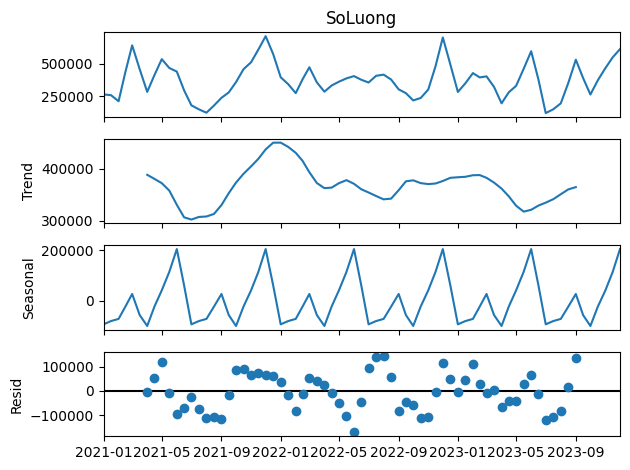

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Đọc dữ liệu từ file CSV
file_path = 'DL_TongHop.csv'  # Đường dẫn đến file CSV của bạn
df = pd.read_csv(file_path)

# Chuyển đổi cột 'Thang' thành datetime và đặt làm chỉ mục
df['Thang'] = pd.to_datetime(df['Thang'], format='%Y-%m')
df.set_index('Thang', inplace=True)

# Xử lý các giá trị NaN trong chuỗi ban đầu bằng cách nội suy
df = df.interpolate()

# Tạo dictionary lưu trữ phương sai phần dư từ chuỗi ban đầu
residual_variances = {}

# Phân rã chuỗi thời gian ban đầu và tính phương sai của phần dư
for column in df.columns:
    result = seasonal_decompose(df[column], model='additive', period=12)  # Chỉnh 'period' theo dữ liệu của bạn
    trend = result.trend
    seasonal = result.seasonal
    residual = df[column] - trend - seasonal
    residual = residual.dropna()  # Loại bỏ giá trị NaN
    residual_variances[column] = residual.var()

# print("Phương sai của phần dư sau khi phân rã từ chuỗi ban đầu:")
# print(residual_variances)

# Nội suy thêm một điểm giữa mỗi cặp điểm
df_interpolated = pd.DataFrame()
for i in range(len(df) - 1):
    row1 = df.iloc[i]
    row2 = df.iloc[i + 1]
    interpolated_row = (row1 + row2) / 2
    interpolated_time = row1.name + (row2.name - row1.name) / 2
    df_interpolated = df_interpolated.append(pd.DataFrame([row1, interpolated_row], index=[row1.name, interpolated_time]))

# Thêm điểm cuối cùng
df_interpolated = df_interpolated.append(df.iloc[-1])

# Xử lý các giá trị NaN trong chuỗi nội suy bằng cách nội suy
df_interpolated = df_interpolated.interpolate()

# Tạo các giá trị nhiễu ngẫu nhiên từ phân phối chuẩn cho các cột nội suy dựa trên phương sai phần dư
for column in df.columns:
    sigma = np.sqrt(residual_variances[column])
    noise = np.random.normal(0, sigma, df_interpolated.shape[0])
    
    # Táo lấy mẫu cho đến khi tất cả các giá trị nằm trong khoảng từ -sigma đến sigma
    while any(abs(noise) > 0.3*sigma):
        noise = np.where(abs(noise) > 0.3*sigma, np.random.normal(0, sigma, df_interpolated.shape[0]), noise)
    
    noise[::2] = 0  # Giữ nguyên các giá trị gốc (các điểm chẵn)
    df_interpolated[column] = df_interpolated[column] + noise

print("Dữ liệu sau khi thêm nhiễu dựa trên phương sai của phần dư:")
print(df_interpolated)

# Hiển thị kết quả phân rã của một cột mẫu
sample_column = df_interpolated.columns[0]
result = seasonal_decompose(df_interpolated[sample_column], model='additive', period=12)
result.plot()
plt.show()


In [2]:
df_interpolated.to_csv('data_final.csv',index = True)